In [28]:
import numpy as np
from core.utils import parse_file, parse_pred_file, parse_attack_files
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = ['10', '6']
import os

from core.utils import get_model_path
from parse import parse

In [2]:
datasets = [
    {
        'absp': '../__histology',
        'label': 'H-MT',
        'color': 'C1',
        'fmt': 'o-'
    },
    {
        'absp': '../__aorta_razv',
        'label': 'X-AO',
        'color': 'C2',
        'fmt': 's-'
    },
    {
        'absp': '../__xray',
        'label': 'X-TB',
        'color': 'C3',
        'fmt': '^-'
    },
    {
        'absp': '../__histology_tifs_2classes_thyroid',
        'label': 'H-TH',
        'color': 'C4',
        'fmt': 'v-'
    },
    {
        'absp': '../__histology_tifs_2classes_ovary',
        'label': 'H-OV',
        'color': 'C5',
        'fmt': 'v--'
    },
    {
        'absp': '../__histology_tifs_4classes',
        'label': 'H-OV-TH',
        'color': 'C6',
        'fmt': 'D-'
    },
    {
        'absp': '../__xray_age_new_20-35_50-70_',
        'label': 'X-NR2',
        'color': 'C7',
        'fmt': '^--'
    },
    {
        'absp': '../__xray_age_new_17-24_25-41_42-80_',
        'label': 'X-NR3',
        'color': 'C8',
        'fmt': 'o--'
    }
]

In [3]:
dataset = datasets[6]

In [4]:
_, labels = parse_file(os.path.join(dataset['absp'], 'test.txt'))
probs = parse_pred_file(os.path.join(dataset['absp'], 'inceptionv3', 'pred_test.pkl'))

a_f = 'a_test_PGD_eps_{0:0.2}_max_iter_{1}.pkl'
a_probs = parse_attack_files(os.path.join(dataset['absp'], 'inceptionv3', a_f), np.arange(1, 21), np.arange(0.02, 0.22, 0.02))

(20, 10, 40000, 2) float32


In [5]:
a_probs_it = a_probs[-1]

i = -1
a_probs_it_eps = a_probs_it[i]

In [6]:
pred_labels = np.argmax(probs, axis=1)
correct_inds = np.where((labels - pred_labels) == 0)[0]

labels_cor = np.array(labels)[correct_inds]
probs_cor = probs[correct_inds]
a_probs_cor = a_probs_it_eps[correct_inds]

In [7]:
pred_labels = np.argmax(probs_cor, axis=1)
a_labels = np.argmax(a_probs_cor, axis=1)
a_inds = np.where((pred_labels - a_labels) != 0)[0]

In [8]:
def logize_probs(probs):
    ln_probs = np.log(probs) - np.log(np.min(probs, axis=0))
    return ln_probs

In [12]:
M = 10

logprobs = logize_probs(probs_cor.T).T
inf_inds = np.where((logprobs.T - logprobs.T)[0] != 0)[0]
notinf_inds = list(set(np.arange(len(logprobs))).difference(set(inf_inds)))
notinf_max = logprobs[notinf_inds].max()
for ind in inf_inds:
    if logprobs[ind][0] == np.inf:
        logprobs[ind][0] = notinf_max + 1
        logprobs[ind][1] = 0
    else:
        logprobs[ind][1] = notinf_max + 1
        logprobs[ind][0] = 0
logprobs = np.max(logprobs, axis=1)
# probs[:20], logprobs[:20]

34006.0

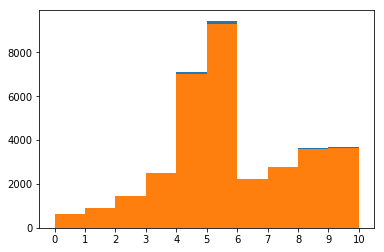

In [13]:
plt.figure()
s = 1
bins = np.arange(0, M + s, s)
plt.xticks(bins)
plt.hist(logprobs, bins=bins)[0].sum()
plt.hist(logprobs[a_inds], bins=bins)[0].sum()

In [15]:
for dataset in datasets:
    _, labels = parse_file(os.path.join(dataset['absp'], 'test.txt'))
    probs = parse_pred_file(os.path.join(dataset['absp'], 'inceptionv3', 'pred_test.pkl'))

    a_f = 'a_test_PGD_eps_{0:0.2}_max_iter_{1}.pkl'
    a_probs = parse_attack_files(os.path.join(dataset['absp'], 'inceptionv3', a_f), np.arange(1, 21), np.arange(0.02, 0.22, 0.02))

    a_probs_it = a_probs[-1]
    i = -1
    a_probs_it_eps = a_probs_it[i]
    
    pred_labels = np.argmax(probs, axis=1)
    correct_inds = np.where((labels - pred_labels) == 0)[0]

    labels_cor = np.array(labels)[correct_inds]
    probs_cor = probs[correct_inds]
    a_probs_cor = a_probs_it_eps[correct_inds]
    
    pred_labels = np.argmax(probs_cor, axis=1)
    a_labels = np.argmax(a_probs_cor, axis=1)
    a_inds = np.where((pred_labels - a_labels) != 0)[0]
    
    dataset.update({
        'labels': labels_cor,
        'probs': probs_cor,
        'a_probs': a_probs_cor,
        'a_inds': a_inds
    })

(20, 10, 30000, 2) float64
(20, 10, 5400, 2) float32
(20, 10, 544, 2) float32
(20, 10, 19072, 2) float32
(20, 10, 19200, 2) float32
(20, 10, 38325, 4) float32
(20, 10, 40000, 2) float32
(20, 10, 110016, 3) float32


In [16]:
M = 10
for dataset in datasets:
    labels_cor = dataset['labels']
    probs_cor = dataset['probs']
    a_probs_cor = dataset['a_probs']
    a_inds = dataset['a_inds']
    
    logprobs = logize_probs(probs_cor.T).T
    inf_inds = np.where((logprobs.T - logprobs.T)[0] != 0)[0]
    notinf_inds = list(set(np.arange(len(logprobs))).difference(set(inf_inds)))
    notinf_max = logprobs[notinf_inds].max()
    for ind in inf_inds:
        if logprobs[ind][0] == np.inf:
            logprobs[ind][0] = notinf_max + 1
            logprobs[ind][1] = 0
        else:
            logprobs[ind][1] = notinf_max + 1
            logprobs[ind][0] = 0
    logprobs = np.max(logprobs, axis=1)
    
    dataset.update({
        'logprobs': logprobs
    })

/home/dmitryvoynov/nn/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/dmitryvoynov/nn/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/dmitryvoynov/nn/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/home/dmitryvoynov/nn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)


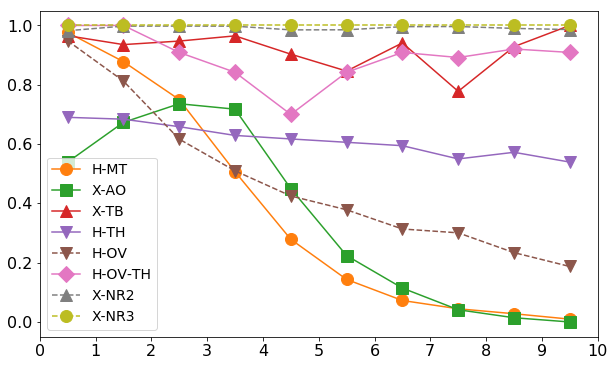

In [39]:
fig = plt.figure()
for dataset in datasets:
    logprobs = dataset['logprobs']
    a_inds = dataset['a_inds']
    
    x = bins[:-1]
    by_bins = np.histogram(logprobs, bins=bins)[0]
    a_by_bins = np.histogram(logprobs[a_inds], bins=bins)[0]
    print(by_bins.shape, a_by_bins.shape)
    y = np.divide(a_by_bins, by_bins)
    plt.plot(x + 0.5, y, dataset['fmt'], label=dataset['label'], color=dataset['color'], markersize=12)


plt.xticks(bins, fontsize=16)
plt.yticks(None, fontsize=16)
plt.legend(fontsize=14)
plt.show()

fig.savefig('plots/rate_by_bins_before_softmax.png', bbox_inches='tight');